In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
import nltk
import re
import string
from  bs4 import BeautifulSoup

#plotting techniques
import matplotlib.pyplot as plt
import seaborn as sns

#splitting data and evalution
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,precision_recall_curve,fbeta_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,f1_score,precision_score,recall_score,accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec,KeyedVectors

#algo.
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#saving model
import pickle

#measure preformance
from tqdm import tqdm
import time

In [2]:
!pip install nltk

In [3]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
data_1 = pd.read_csv("IMDB-Dataset1.csv")
data_2 = pd.read_csv("IMDB-Dataset2.csv",header=None)

In [6]:
data_2.columns=['review','sentiment']

In [7]:
df = pd.concat([data_1,data_2],ignore_index=True)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
#Dropping duplicate entries comments & sentiments

filtered_data= df.drop_duplicates(subset = {"review",'sentiment'},keep = 'first',inplace = False)
filtered_data.shape

(49582, 2)

In [9]:
#checking to see how much % data still remain 

display(((filtered_data['review'].size*1.0)/(df['review'].size*1.0)*100))

99.164

In [10]:
#To check how many +ve &-ve reviews are present in Database

filtered_data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

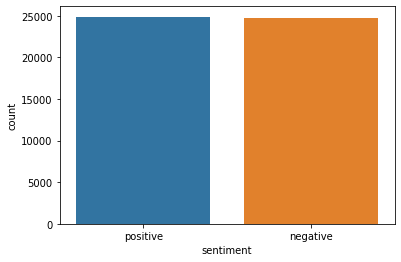

In [11]:
sns.countplot(filtered_data['sentiment'],data=filtered_data)

In [12]:
#for convert the object to int
comman_encod=LabelEncoder()

In [13]:
filtered_data['sentiment'] = comman_encod.fit_transform(filtered_data['sentiment'].values.reshape(-1,1))

#### Observation :- 
    Our data is balanced 

**## Preprocessing of data**

Now that we have finished duplication our data requires some pre processing before we go on further with analysis 7 making the prediction model.

Hence it's pre processing phase we do in the order below :-

1.Begin by removing HTML Tags.

2.Remove punctuation or limited set of special characters .

3.Check if the word is made up of english letter or alphanumeric.

4.Check to see if the length of the word is >2(it was researched that there is no adjective in 2 letters)

5.Convert the word in lowercase.

6.Remove stopwords.

7.Apply stemming

In [14]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"aren\'t", "are not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase

In [15]:
stop_words= set(stopwords.words('english'))
punct = string.punctuation

In [16]:
def lem(t):
    lemma = WordNetLemmatizer()
    l =[]
    tok = nltk.word_tokenize(t)
    for i in tok:
        l.append(lemma.lemmatize(i))
    s=" ".join(l)
    return s        

In [17]:
def cleand_text(t):
    lis = []
    for word in nltk.word_tokenize(t.lower()):
        if word not in punct:
            if word not in stop_words:
                lis.append(word)
    s=" ".join(lis)
    return s

In [21]:
from tqdm import tqdm

processed_comments = []

for sentence in tqdm(filtered_data['review'].values):
    sentence = re.sub(r"http\S+","",sentence)
    sentence = BeautifulSoup(sentence,'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = lem(sentence)
    sentence = re.sub("\S*\d\S*","",sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ',sentence)
    sentence = re.sub(r'[^\x00-\x7f]',r' ', sentence)
    sentence = cleand_text(sentence)
    #sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words and e.lower() not in punct)
    processed_comments.append(sentence.strip()) 

100%|██████████| 49582/49582 [03:43<00:00, 222.08it/s]


In [22]:
#By using Countvectorizer

cv= CountVectorizer(binary=True,ngram_range=(2, 2))
cv_x = cv.fit_transform(processed_comments)

In [23]:
#By using Tf-idf vectorizer

tf= TfidfVectorizer(binary=True,ngram_range=(2, 2))
tf_x = tf.fit_transform(processed_comments)

In [24]:
y = filtered_data['sentiment']

In [25]:
print(cv_x.shape)
print(tf_x.shape)

(49582, 2893308)
(49582, 2893308)


In [26]:
def overall_output(y_test,y_pred):
    print (" Classification Report \n ",classification_report(y_test,y_pred,digits=2))
    
    cfm = confusion_matrix(y_test,y_pred)

    print(" Confusion Matrix \n ",cfm)
    
    t_p = cfm[0][0]
    f_p = cfm[0][1]
    f_n = cfm[1][0]
    t_n = cfm[1][1]
    
    Precision = t_p/(t_p+f_p)
    Recall = t_p/(t_p+f_n)    
    print("\n")

    print("F1_Score : ", 2*((Precision*Recall)/(Precision+Recall)))
    
    #AUC
    auc = roc_auc_score(y_test,y_pred)
    
    fpr,tpr,threshold = roc_curve(y_test,y_pred)
    
    plt.plot(fpr,tpr,color="orange",label='ROC')
    plt.plot([0,1],[0,1],color = 'darkblue',linestyle='--',label='ROC Curve(area = %0.3f)'%auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()    

Algorithm implementation

 Classification Report 
                precision    recall  f1-score   support

           0       0.90      0.88      0.89      6174
           1       0.89      0.90      0.90      6222

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

 Confusion Matrix 
  [[5451  723]
 [ 596 5626]]


F1_Score :  0.8920710252843466


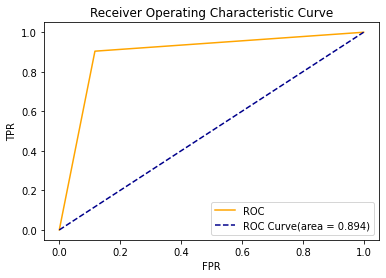

In [27]:
#By using Tf-idf vectorizer

tf= TfidfVectorizer(binary=True)
tf_x = tf.fit_transform(processed_comments)


#train test split
x_train,x_test,y_train,y_test = train_test_split(tf_x,y,train_size=0.75)

lr = LogisticRegression(C=0.75)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
overall_output(y_test,y_pred)

In [28]:
cv_score = cross_val_score(lr,tf_x,y,cv=10,scoring='accuracy')

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",cv_score.mean() * 100)

Accuracy of Model with Cross Validation is: 89.43970286075549


In [29]:
lr = LogisticRegression()

In [36]:
#Hyper parameter tuning

paramgrid =[{'penalty' : ['l2','none'],'C':np.logspace(-4, 4, 20),
             'solver' : ['newton-cg'],
             'max_iter' : [5000,6000,7000]}]

In [37]:
grdcv = GridSearchCV(estimator=lr,param_grid=paramgrid,cv =3, verbose=True, n_jobs=-1)

In [38]:
best_clf = grdcv.fit(tf_x,y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [39]:
best_clf.best_estimator_

LogisticRegression(C=4.281332398719396, max_iter=5000, solver='newton-cg')

 Classification Report 
                precision    recall  f1-score   support

           0       0.90      0.88      0.89      6186
           1       0.88      0.90      0.89      6210

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396

 Confusion Matrix 
  [[5442  744]
 [ 615 5595]]


F1_Score :  0.8889977946581721


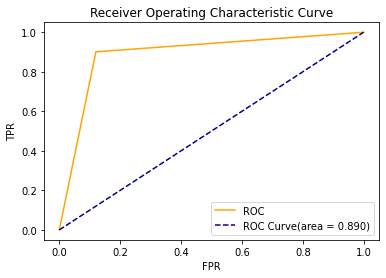

In [41]:
#train test split
x_train,x_test,y_train,y_test = train_test_split(tf_x,y,train_size=0.75)

lr = LogisticRegression(C=4.281332398719396, max_iter=5000, solver='newton-cg')
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
overall_output(y_test,y_pred)

In [42]:
cv_score = cross_val_score(lr,tf_x,y,cv=10,scoring='accuracy')

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",cv_score.mean() * 100)

Accuracy of Model with Cross Validation is: 89.67567657046757


In [44]:
#Saving the model
import pickle
filename = 'income.pkl'
pickle.dump(lr,open(filename,'wb'))

### Conclusion :

In [45]:
loaded_model = pickle.load(open('income.pkl','rb'))
result = loaded_model.score(x_test,y_test)
print(result*100)

89.03678606001935


In [46]:
y_pred[:]

array([1, 0, 1, ..., 1, 0, 1])

In [48]:
conclusion = pd.DataFrame([loaded_model.predict(x_test)[:],y_pred[:]],index=["predicted","original"])

conclusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374,12375,12376,12377,12378,12379,12380,12381,12382,12383,12384,12385,12386,12387,12388,12389,12390,12391,12392,12393,12394,12395
predicted,1,0,1,1,0,1,0,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1
original,1,0,1,1,0,1,0,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1
